# Notebook to illustrate camera self-calibration algorithm

We want to estimate $3 \times 3$ $ K $ camera matrix of form:

$ K = \begin{bmatrix} f_x \ 0 \ c_x \\ 0 \ f_y \ c_y \\ 0 \ 0 \ 1 \end{bmatrix} $ <br>

For that we assume that we have $ M $ images (taken by the exact same camera, so $ K $ stays the same) of an object. In each image a set of $ N $ corresponding points have been identified.

Using these corresponding points we can calculate fundamental matrix $ F_i $ for each $ i = 1, ..., (M - 1) $ view pairs, e.g. by using cv2.findFundamentalMat() function from OpenCV.
Those fundamental matrices can be further used to calculate projection matrices for each camera pair, when using the first camera as reference.
For this we can use the procedure described here: https://users.cecs.anu.edu.au/~hartley/Papers/PDF/Hartley:Encyclopedia.pdf


<!-- Let's assume that we are given the following matrices:
1. $3 \times 3$ camera intrinsic matrix $M$ of form: $ M = \begin{bmatrix} f_x \ 0 \ c_x \\ 0 \ f_y \ c_y \\ 0 \ 0 \ 1 \end{bmatrix} $ <br>
2. $3 \times 4$ world-to-camera transformation matrix $W$ of form: $W = [R | t]$
3. vector $(u, v, 1) $ holding pixel coordinates in undistorted image

Then we can define a $3 \times 4$ camera projection matrix $P$ of form:

$ P = M \cdot W$ <br>

Let's mark each row in $P$ like this:

$ P = \begin{bmatrix} p_1 \\ p_2 \\ p_3 \end{bmatrix} $ <br>

Then we can create a following homogenous linear equation system, which general form is of form $A \cdot x = 0$:

[1] $ A \cdot \begin{bmatrix} x_w \\ y_w \\ z_w \\ w \end{bmatrix} = 0$ <br>

where:

[2] $ A = \begin{bmatrix} u \cdot p_3^T - p_1^T \\ v \cdot p_3^T - p_2^T \end{bmatrix} $ <br>

$A$ is a $2 \times 4$ matrix.

Of course in case of a single camera view we have 4 unknowns $x_w$, $y_w$, $z_w$ and $w$, but only 2 equations, in order to find the unknowns we need to add more views.
If we denote A matrices for 1, 2, and N view as: $A_1$, $A_2$ and $A_N$ we can create the following homogenous linear equation system:

[3] $ \begin{bmatrix} A_1 \\ A_2 \\ ...\\ A_N \end{bmatrix} \cdot \begin{bmatrix} x_w \\ y_w \\ z_w \\ w \end{bmatrix} = 0$ <br>

where A is a $ (2 \cdot N) \times 4 $ matrix.

Then solution for $x$ is the last column of V where $A=UDV^T$ and $UDV^T$ is taken from SVD. -->

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# set NumPy print precision for better readability
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

In [2]:
# load data dumped using face keypoint extraction script
DATA_ROOT = '/home/kjduzink/SourceCode/web-eye-tracking-algo/code/tools/modules'

frames = []
face_keypoints_list = []

for i in range(9):
    filename = f'frame_kpts_{i}.npy'
    with open(os.path.join(DATA_ROOT, filename), 'rb') as f:
        frame = np.load(f)
        face_keypoints = np.load(f)

    frames.append(frame)
    face_keypoints_list.append(face_keypoints)

## Inspect the data and select images that have proper looking landmarks

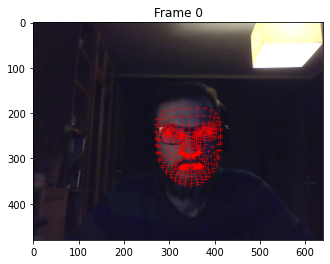

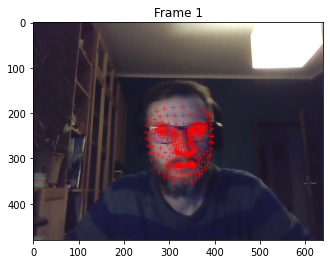

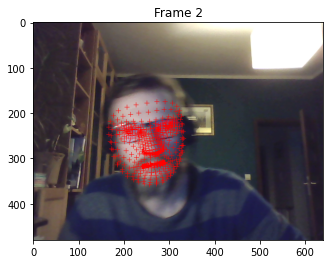

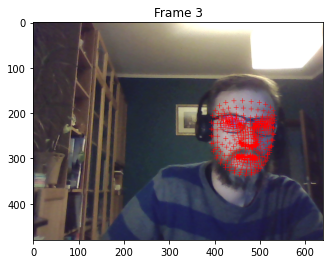

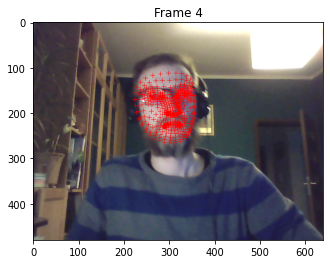

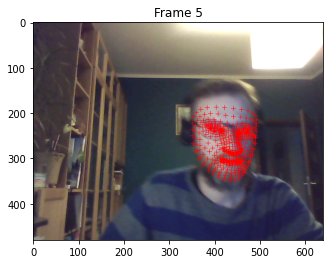

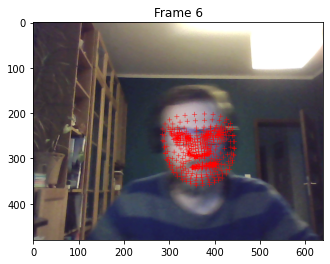

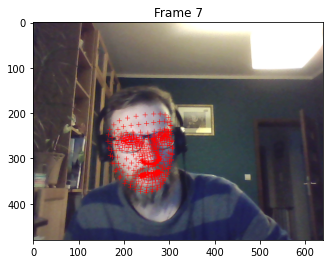

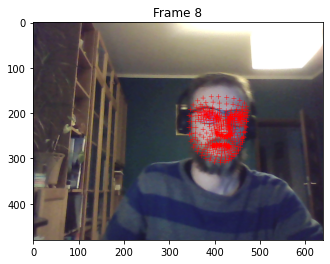

In [3]:
# display loaded data
index = 0
for frame, face_keypoints in zip(frames, face_keypoints_list):
    frame_with_kpts = frame.copy()

    for face_keypoint in face_keypoints:
        frame_with_kpts = cv2.drawMarker(frame, np.array(face_keypoint, dtype=int), color=(0, 0, 255), markerSize=10)

    plt.imshow(cv2.cvtColor(frame_with_kpts, cv2.COLOR_BGR2RGB))
    plt.title(f'Frame {index}')
    plt.show()

    index += 1


In [4]:
VALID_FRAME_INDEXES = [0, 1, 2, 3, 4, 7, 8]

In [5]:
# extract valid data
valid_frames = [frames[i] for i in VALID_FRAME_INDEXES]
assert len(valid_frames) == len(VALID_FRAME_INDEXES)

valid_face_keypoints_list = [face_keypoints_list[i] for i in VALID_FRAME_INDEXES]
assert len(valid_face_keypoints_list) == len(VALID_FRAME_INDEXES)

print(f'Selected {len(valid_frames)} frame data as valid')

Selected 7 frame data as valid


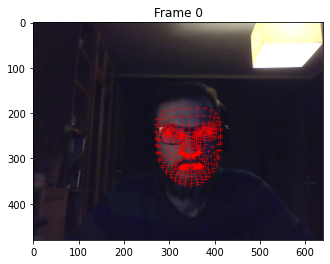

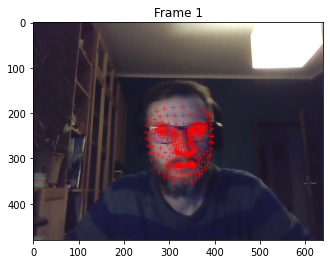

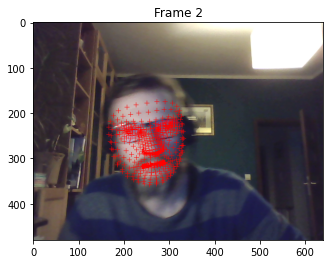

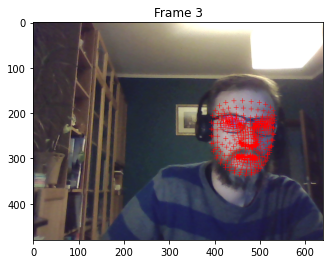

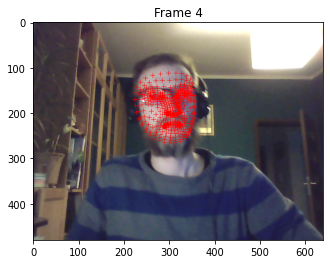

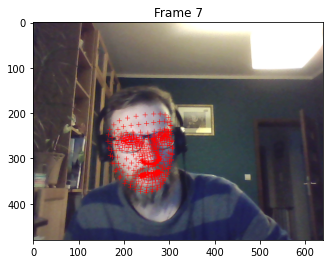

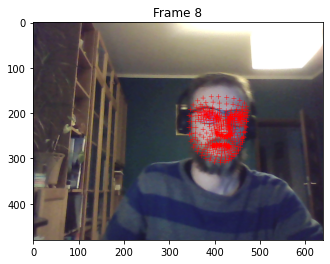

In [6]:
# display valid frames
for i, (frame, face_keypoints) in enumerate(zip(valid_frames, valid_face_keypoints_list)):
    frame_with_kpts = frame.copy()

    for face_keypoint in face_keypoints:
        frame_with_kpts = cv2.drawMarker(frame, np.array(face_keypoint, dtype=int), color=(0, 0, 255), markerSize=10)

    plt.imshow(cv2.cvtColor(frame_with_kpts, cv2.COLOR_BGR2RGB))
    plt.title(f'Frame {VALID_FRAME_INDEXES[i]}')
    plt.show()


## Compute fundamental matrices for all view pairs

In [7]:
# define view pairs
view_pairs = [(VALID_FRAME_INDEXES[0], i) for i in VALID_FRAME_INDEXES[1:]]
print(view_pairs)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 7), (0, 8)]


In [25]:
# calculate fundamental matrix for each view pair
fundamental_matrices = []
for view_pair in view_pairs:
    F, mask = cv2.findFundamentalMat(points1=face_keypoints_list[view_pair[0]], points2=face_keypoints_list[view_pair[1]], method=cv2.FM_LMEDS)

    # select only inlier points
    inlier_pts1 = face_keypoints_list[view_pair[0]][mask.ravel()==1]
    inlier_pts2 = face_keypoints_list[view_pair[1]][mask.ravel()==1]
    assert len(inlier_pts1) == len(inlier_pts2)

    print(f'### View pair: {view_pair} ###')
    print(f'Fundamental matrix:\n{F}')
    print(f'Inliers count: {len(inlier_pts1)}')
    print('')

    fundamental_matrices.append(F)

### View pair: (0, 1) ###
Fundamental matrix:
[[0.00000 -0.00000 0.00212]
 [0.00001 0.00000 0.01085]
 [-0.00463 -0.01490 1.00000]]
Inliers count: 416

### View pair: (0, 2) ###
Fundamental matrix:
[[0.00000 -0.00002 0.00571]
 [0.00002 0.00000 -0.00685]
 [-0.00699 0.00317 1.00000]]
Inliers count: 407

### View pair: (0, 3) ###
Fundamental matrix:
[[0.00000 0.00001 -0.00123]
 [-0.00001 0.00000 0.00626]
 [-0.00094 -0.01008 1.00000]]
Inliers count: 431

### View pair: (0, 4) ###
Fundamental matrix:
[[-0.00001 0.00001 0.00443]
 [-0.00000 0.00002 0.00253]
 [-0.00170 -0.01103 1.00000]]
Inliers count: 351

### View pair: (0, 7) ###
Fundamental matrix:
[[0.00000 -0.00002 0.00703]
 [0.00001 0.00000 -0.01566]
 [-0.00830 0.01579 1.00000]]
Inliers count: 384

### View pair: (0, 8) ###
Fundamental matrix:
[[-0.00000 0.00001 -0.00204]
 [-0.00001 0.00001 0.00502]
 [0.00174 -0.01103 1.00000]]
Inliers count: 372



### Experimental calculations of 1st pair of projection matrices

(0, 2)


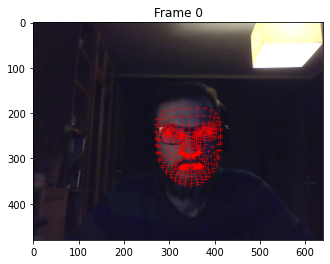

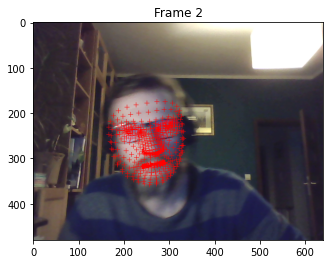

In [18]:
# pick a view pair
VIEW_PAIR_INDEX = 1

# display the analyzed view pair
view_pair_indices = view_pairs[VIEW_PAIR_INDEX]
print(view_pair_indices)

# 1st image in pair
frame_with_kpts = frames[view_pair_indices[0]].copy()

for face_keypoint in face_keypoints_list[view_pair_indices[0]]:
    frame_with_kpts = cv2.drawMarker(frame_with_kpts, np.array(face_keypoint, dtype=int), color=(0, 0, 255), markerSize=10)

plt.imshow(cv2.cvtColor(frame_with_kpts, cv2.COLOR_BGR2RGB))
plt.title(f'Frame {view_pair_indices[0]}')
plt.show()

# 2nd image pair
frame_with_kpts = frames[view_pair_indices[1]].copy()

for face_keypoint in face_keypoints_list[view_pair_indices[1]]:
    frame_with_kpts = cv2.drawMarker(frame_with_kpts, np.array(face_keypoint, dtype=int), color=(0, 0, 255), markerSize=10)

plt.imshow(cv2.cvtColor(frame_with_kpts, cv2.COLOR_BGR2RGB))
plt.title(f'Frame {view_pair_indices[1]}')
plt.show()



In [19]:
# pick the first fundamental matrix
F = fundamental_matrices[VIEW_PAIR_INDEX]
print(F.shape)

# perform SVD of fundamental matrix
U, D, Vt = np.linalg.svd(F)

# extract singular values
p = D[0]
q = D[1]
r = 1.0  # arbitrary chosen value

print(f'U:\n{U}')
print(f'D:\n{D}')
print(f'Vt:\n{Vt}')

print(f'p: {p}')
print(f'q: {q}')

# define helper matrices
W = np.array([
    [0.0, -1.0, 0.0],
    [1.0,  0.0, 0.0],
    [0.0,  0.0, 1.0]
])

Z = np.array([
    [0.0, -1.0, 0.0],
    [1.0,  0.0, 0.0],
    [0.0,  0.0, 0.0]
])

# define D_dash diagonal matrix
D_dash = np.diag([p, q, r])
print(f'D_dash: {D_dash}')

# define M matrix such that: F = U*D*Vt = (U*Z*Vt) (U*W.t*D_dash*Vt) = S*M
M = U @ W.T @ D_dash @ Vt
print(f'M:\n{M}')

# extract u3 (3rd column of U matrix)
u3 = U[:, 2].reshape(3, -1)
print(f'u3:\n{u3}')

# pair of camera matrices corresponding to the fundamental matrix F is defined as
P1 = np.hstack((np.identity(3), np.zeros((3, 1))))
print(f'P1:\n{P1}')
print(f'P1.shape: {P1.shape}')

P2 = np.hstack((M, u3))
print(f'P2:\n{P2}')

(3, 3)
U:
[[0.00571 0.83891 0.54424]
 [-0.00685 -0.54420 0.83893]
 [0.99996 -0.00852 0.00264]]
D:
[1.00007 0.00007 0.00000]
Vt:
[[-0.00699 0.00317 0.99997]
 [0.74026 -0.67228 0.00731]
 [0.67228 0.74029 0.00235]]
p: 1.000069238263656
q: 6.778088257567295e-05
D_dash: [[1.00007 0.00000 0.00000]
 [0.00000 0.00007 0.00000]
 [0.00000 0.00000 1.00000]]
M:
[[0.37174 0.40023 -0.83767]
 [0.56019 0.62278 0.54620]
 [0.00177 0.00194 0.00852]]
u3:
[[0.54424]
 [0.83893]
 [0.00264]]
P1:
[[1.00000 0.00000 0.00000 0.00000]
 [0.00000 1.00000 0.00000 0.00000]
 [0.00000 0.00000 1.00000 0.00000]]
P1.shape: (3, 4)
P2:
[[0.37174 0.40023 -0.83767 0.54424]
 [0.56019 0.62278 0.54620 0.83893]
 [0.00177 0.00194 0.00852 0.00264]]


### Sanity check of the projection matrices calculation

In [20]:
# triangulate the face keypoints from 2 views to extract the 3D location
# NOTE: Since it was the face that was moving in front of a camera in constant location we need to interpret the
#       triangulation result as face location in 1st camera view in CCS.

print(face_keypoints_list[0].shape)
print(face_keypoints_list[1].shape)

point_4d = cv2.triangulatePoints(P1, P2, face_keypoints_list[0][0], face_keypoints_list[1][0])
print(point_4d.shape)
print(f'point_4d: {point_4d}')
point_3d = point_4d / point_4d[3]
print(f'point_3d: {point_3d}')


(478, 2)
(478, 2)
(4, 1)
point_4d: [[0.52946]
 [0.47347]
 [0.00151]
 [-0.70392]]
point_3d: [[-0.75215]
 [-0.67261]
 [-0.00215]
 [1.00000]]


In [22]:
def compute_projection_matrices(fundamental_matrices: list) -> list:
    """Computes projection matrices for each view pair based on fundamental matrices

    Args:
        fundamental_matrices: list of fundamental matrices calculated for each view pair

    Returns:
        list of calculated projection matrices
    """

    # define helper matrices
    W = np.array([
        [0.0, -1.0, 0.0],
        [1.0,  0.0, 0.0],
        [0.0,  0.0, 1.0]
    ])

    Z = np.array([
        [0.0, -1.0, 0.0],
        [1.0,  0.0, 0.0],
        [0.0,  0.0, 0.0]
    ])

    projection_matrices = []
    projection_matrices.append(np.hstack((np.identity(3), np.zeros((3, 1)))))

    for F in fundamental_matrices:

        # perform SVD of a given fundamental matrix
        U, D, Vt = np.linalg.svd(F)

        # extract singular values
        p = D[0]
        q = D[1]
        r = 1.0  # arbitrary chosen value

        # define D_dash diagonal matrix
        D_dash = np.diag([p, q, r])

        # define M matrix such that: F = U*D*Vt = (U*Z*Vt) (U*W.t*D_dash*Vt) = S*M
        M = U @ W.T @ D_dash @ Vt

        # extract u3 (3rd column of U matrix)
        u3 = U[:, 2].reshape(3, -1)

        # projection matrix for the 2nd view
        P = np.hstack((M, u3))
        projection_matrices.append(P)

    assert len(projection_matrices) == len(fundamental_matrices) + 1
    return projection_matrices


In [24]:
projection_matrices = compute_projection_matrices(fundamental_matrices)

print(f'1st projection matrix:\n{projection_matrices[0]}')
print(f'2nd projection matrix:\n{projection_matrices[1]}')
print(f'3rd projection matrix:\n{projection_matrices[2]}')

1st projection matrix:
[[1.00000 0.00000 0.00000 0.00000]
 [0.00000 1.00000 0.00000 0.00000]
 [0.00000 0.00000 1.00000 0.00000]]
2nd projection matrix:
[[-0.92465 0.33772 0.17600 0.98453]
 [0.15985 -0.07524 0.98439 -0.17521]
 [0.00016 -0.00007 -0.01105 -0.00019]]
3rd projection matrix:
[[0.37174 0.40023 -0.83767 0.54424]
 [0.56019 0.62278 0.54620 0.83893]
 [0.00177 0.00194 0.00852 0.00264]]


## Camera Self-Calibration Algorithm

In [26]:
def auto_calibration(
            P_Ix3x4,
            ry: float = 1.0
        ):
    '''
        Autocalibration and the Absolute Quadric:
        https://hal.inria.fr/inria-00548345/document

        Self-Calibration and Metric Reconstruction in spite of Varying and
        Unknown Intrinsic Camera Parameter:
        https://people.inf.ethz.ch/pomarc/pubs/PollefeysIJCV99.pdf

        Notes:

        >>> W* = P @ Q* @ P.T

        >>> if W* = [ [ r**2 *fy**2, 0    , 0 ],
                        [ 0          , fx**2, 0 ],
                        [ 0          , 0   ,  1 ] ]:
        (1)         W[0, 2] = 0        (principal point (p.p) at origin)
        (2)         W[1, 2] = 0        (principal point (p.p) at origin)
        (3)         W[0, 1] = 0        (zero skew if p.p at origin)
        (4)  ry**2 *W[0, 0] = W[1, 1]  (known aspect ratio ry=fy/fx)

        >>> Q* = [[q1 , q2 , q3 , q4 ],
                    [q5 , q6 , q7 , q8 ],
                    [q9 , q10, q11, q12],
                    [q13, q14, q15, q16]]; q5=q2, q9=q3, q13=q4, q10=q7, q14=q8, q15=q12

        >>> H^ = [[ lambda *R, t ]
                    [         0, 1 ]] - up to scale !!!

        Other materials:
        https://github.com/nbarba/py3DRec/blob/master/uncalibrated_rec.py
    '''
    r2 = ry**2
    A = np.vstack([[
            #      q1,     q2+   q5,     q3+    q9,     q4+   q13,     q6,     q7+   q10,     q8+   q14,    q11,    q12+   q15,    q16
            # (1)
                [ p1*p9 , p1*p10+p2*p9, p1*p11+p3*p9 , p1*p12+p4*p9 , p2*p10, p2*p11+p3*p10, p2*p12+p4*p10, p3*p11, p3*p12+p4*p11, p4*p12 ],
            # (2)
                [ p5*p9 , p5*p10+p6*p9, p5*p11+p7*p9 , p5*p12+p8*p9 , p6*p10, p6*p11+p7*p10, p6*p12+p8*p10, p7*p11, p7*p12+p8*p11, p8*p12 ],
            # (3)
                [ p1*p5 , p1*p6 +p2*p5, p1*p7 +p3*p5 , p1*p8 +p4*p5 , p2*p6 , p2*p7 +p3*p6 , p2*p8 +p4*p6 , p3*p7 , p3*p8 +p4*p7 , p4*p8  ],
            #
            #     q1      p1,         q2+q5     q2+q5,      q3+q9     q3+q9,     q4+q13    q4+q13,       q6      q6,     q7+q10    q7+q10,     q8+q14    q8+q14,      q11     q11,    q12+q15   q12+q15,     q16     q16
            # (4)
                [ r2*p1**2 - p5**2, r2*2*p1*p2 - 2*p5*p6, r2*2*p1*p3 - 2*p5*p7, r2*2*p1*p4 - 2*p5*p8, r2*p2**2 - p6**2, r2*2*p2*p3 - 2*p6*p7, r2*2*p2*p4 - 2*p6*p8, r2*p3**2 - p7*p7, r2*2*p3*p4 - 2*p7*p8, r2*p4**2 - p8**2],
            ] for [p1, p2, p3, p4], [p5, p6, p7, p8], [p9, p10, p11, p12] in P_Ix3x4
        ])
    _, S, Vt = np.linalg.svd(A)
    q1, q2, q3, q4, q6, q7, q8, q11, q12, q16 = Vt.T[:, -1]
    Qstar_4x4_hat = np.array([
            [q1, q2, q3 , q4 ],
            [q2, q6, q7 , q8 ],
            [q3, q7, q11, q12],
            [q4, q8, q12, q16],
        ], dtype=np.float64)
    # np.linalg.det(Qstar_4x4_hat) == 0

    H_4x4_hat, S, _ = np.linalg.svd(Qstar_4x4_hat); S[-1] = 1
    H_4x4_hat = np.dot(H_4x4_hat, np.diag(np.sqrt(S)))
    # Qstar_4x4_hat ==  H_4x4_hat @ np.diag([1, 1, 1, 0]) @ H_4x4_hat.T

    Wstar_Ix3x3_hat = [ P_3x4 @ Qstar_4x4_hat @ P_3x4.T for P_3x4 in P_Ix3x4]
    Wstar_Ix3x3_hat = [ Wstar_3x3_hat/Wstar_3x3_hat[-1, -1] for Wstar_3x3_hat in Wstar_Ix3x3_hat]

    C_Ix3x3_hat = [np.linalg.cholesky(Wstar_3x3_hat) for Wstar_3x3_hat in Wstar_Ix3x3_hat]

    return C_Ix3x3_hat, H_4x4_hat

In [33]:
C_Ix3x3_hat, H_4x4_hat = auto_calibration(projection_matrices)

for i, camera_matrix in enumerate(C_Ix3x3_hat):
    print(f'{i}-th camera matrix:\n{camera_matrix}')
    print('')

0-th camera matrix:
[[16.53290 0.00000 0.00000]
 [-0.00038 16.53304 0.00000]
 [0.00327 0.00944 0.99995]]

1-th camera matrix:
[[92.50662 0.00000 0.00000]
 [7.38049 91.46074 0.00000]
 [-0.26821 -0.92836 0.25733]]

2-th camera matrix:
[[131.60254 0.00000 0.00000]
 [20.66161 117.13951 0.00000]
 [-0.59763 0.79116 0.12999]]

3-th camera matrix:
[[158.51057 0.00000 0.00000]
 [8.95102 160.13628 0.00000]
 [0.13558 -0.97563 0.17253]]

4-th camera matrix:
[[196.22215 0.00000 0.00000]
 [4.44677 197.50626 0.00000]
 [-0.84997 -0.47358 0.23080]]

5-th camera matrix:
[[57.37589 0.00000 0.00000]
 [7.97365 64.22774 0.00000]
 [-0.23909 0.92929 0.28153]]

6-th camera matrix:
[[192.88400 0.00000 0.00000]
 [-11.65603 180.51705 0.00000]
 [0.44532 -0.87168 0.20459]]

